# NaK model analysis

Here we will show you the neurodynamics analysis of a two-dimensional system model with the example of the $I_{\rm{Na,p+}}-I_K$ Model. 

The dynamical system is given by:
$$ C\dot{V} = I_{ext} - g_L * (V-E_L)-g_{Na}*m_\infty(V)(V-E_{Na})-g_K*n*(V-E_K)$$

$$ \dot{n} = \frac{n_\infty(V)-n}{\tau(V)} $$

where

$$ m_\infty(V) = 1 \ / \ ({1+\exp(\frac{V_{\rm{n_{half}}}-V}{k_m})}) $$

$$ n_\infty(V) = 1 \ / \ ({1+\exp(\frac{V_{\rm{n_{half}}}-V}{k_n})}) $$

This model specifies a leak current $I_L$, persistent sodium current $I_{\rm{Na, p}}$ 
with instantaneous activation kinetic, and a relatively slower persistent 
potassium current $I_K$ with either high or low threshold (the two choices 
result in fundamentally different dynamics). 

In [1]:
from collections import OrderedDict

import brainpy as bp

bp.backend.set(dt=0.02)

In [2]:
C = 1
E_L = -78  # different from high-threshold model
g_L = 8
g_Na = 20
g_K = 10
E_K = -90
E_Na = 60
Vm_half = -20
k_m = 15
Vn_half = -45  # different from high-threshold model
k_n = 5
tau = 1

@bp.odeint
def integral(V, n, t, Iext):
    m_inf = 1 / (1 + bp.backend.exp((Vm_half - V) / k_m))
    I_leak = g_L * (V - E_L)
    I_Na = g_Na * m_inf * (V - E_Na)
    I_K = g_K * n * (V - E_K)
    dvdt = (-I_leak - I_Na - I_K + Iext) / C
        
    n_inf = 1 / (1 + bp.backend.exp((Vn_half - V) / k_n))
    dndt = (n_inf - n) / tau
    
    return dvdt, dndt

### Phase plane analysis

plot nullcline ...
SymPy solve "integral(V, n) = 0" to "n = f(V, )", success.
SymPy solve "integral(V, n) = 0" to "n = f(V, )", success.
plot vector field ...


:2: RuntimeWarning: divide by zero encountered in true_divide


plot fixed point ...
SymPy solve derivative of "integral(V, n)" by "V", success.
SymPy solve derivative of "integral(V, n)" by "n", success.
SymPy solve derivative of "integral(V, n)" by "V", success.
SymPy solve derivative of "integral(V, n)" by "n", success.
Fixed point #1 at V=-51.60868767199546, n=0.2105293582848025 is a unstable focus.
plot trajectory ...


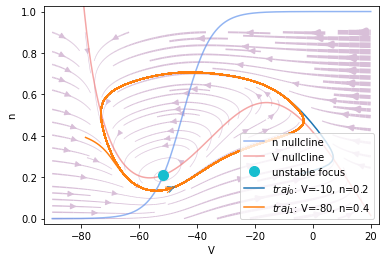

In [3]:
analyzer = bp.analysis.PhasePlane(
    integral,
    target_vars=OrderedDict(V=[-90, 20], n=[0., 1.]),
    pars_update={'Iext': 50.})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': -10, 'n': 0.2}, {'V': -80, 'n': 0.4}],
                         duration=100.,
                         show=True)

### Codimension 1 bifurcation analysis

Here we show the codimension 1 bifurcation analysis of the $I_{\rm{Na,p+}}-I_K$ Model, in which $I_{ext}$ is varied in [0., 50.].

plot bifurcation ...
SymPy solve "integral(V, n, Iext) = 0" to "n = f(V, Iext)", success.
SymPy solve derivative of "integral(V, n, Iext)" by "V", success.
SymPy solve derivative of "integral(V, n, Iext)" by "n", success.
SymPy solve derivative of "integral(V, n, Iext)" by "V", success.
SymPy solve derivative of "integral(V, n, Iext)" by "n", success.


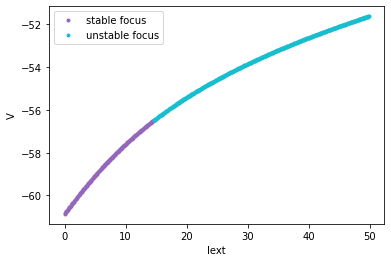

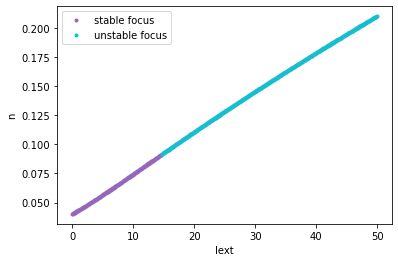

In [4]:
analyzer = bp.analysis.Bifurcation(
    integral,
    target_pars={'Iext': [0, 50.]},
    target_vars={"V": [-90., 20.], 'n': [0., 1.]},
    numerical_resolution=0.1)
analyzer.plot_bifurcation(show=True)

### Codimension 2 bifurcation analysis

Codimension 2 bifurcation analysis of the $I_{\rm{Na,p+}}-I_K$ Model, in which $I_{ext}$ is varied in [0., 50.], and "Vn_half" is varied in [-50, -40].

plot bifurcation ...
SymPy solve "integral(V, n, Iext, Vn_half) = 0" to "n = f(V, Iext,Vn_half)", success.
SymPy solve derivative of "integral(V, n, Iext, Vn_half)" by "V", success.
SymPy solve derivative of "integral(V, n, Iext, Vn_half)" by "n", success.
SymPy solve derivative of "integral(V, n, Iext, Vn_half)" by "V", success.
SymPy solve derivative of "integral(V, n, Iext, Vn_half)" by "n", success.


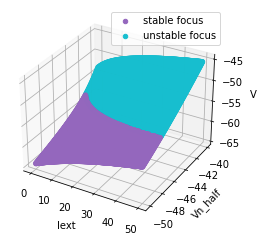

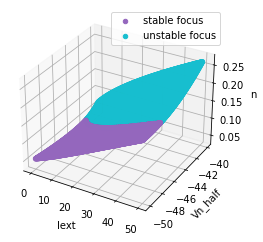

In [5]:
analyzer = bp.analysis.Bifurcation(
    integral,
    target_pars={'Iext': [0, 50.], 'Vn_half': [-50, -40]},
    target_vars={"V": [-90., 20.], 'n': [0., 1.]},
    numerical_resolution=0.1)

analyzer.plot_bifurcation(show=True)

### Reference

[1] Izhikevich, Eugene M. Dynamical systems in neuroscience (Chapter 
4). MIT press, 2007.